In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohitsingh1804/plantvillage


Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
 99% 809M/818M [00:04<00:00, 131MB/s]
100% 818M/818M [00:04<00:00, 181MB/s]


In [ ]:
!unzip plantvillage.zip


Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

In [ ]:
import os

os.listdir()


['.config', 'PlantVillage', 'plantvillage.zip', 'kaggle.json', 'sample_data']

In [ ]:
len(os.listdir("PlantVillage"))
os.listdir("PlantVillage")



['val', 'train']

In [ ]:
train_dir = "/content/PlantVillage/train"
val_dir   = "/content/PlantVillage/val"


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Increased from 20 to handle shaky hands
    width_shift_range=0.2,   # Moves image left/right (if leaf isn't centered)
    height_shift_range=0.2,  # Moves image up/down
    shear_range=0.2,         # Distorts image (different camera angles)
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'      # Fills in pixels lost during rotation/shifting
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


In [ ]:
print("Classes:", train_data.num_classes)
print(train_data.class_indices)


Classes: 38
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight':

In [ ]:
import numpy as np

class_names = list(train_data.class_indices.keys())



Label vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class name: Soybean___healthy


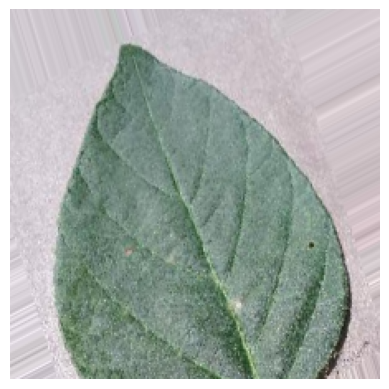

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(train_data)

plt.imshow(images[0])
plt.axis('off')
label_index = np.argmax(labels[0])

print("Label vector:", labels[0])
print("Class name:", class_names[label_index])



In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True


In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [22]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30
)


Epoch 1/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 686s 505ms/step - accuracy: 0.5871 - loss: 1.5233 - val_accuracy: 0.9170 - val_loss: 0.2550
Epoch 2/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 647s 476ms/step - accuracy: 0.8818 - loss: 0.3802 - val_accuracy: 0.9476 - val_loss: 0.1577
Epoch 3/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 647s 477ms/step - accuracy: 0.9238 - loss: 0.2463 - val_accuracy: 0.9641 - val_loss: 0.1077
Epoch 4/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 643s 474ms/step - accuracy: 0.9421 - loss: 0.1900 - val_accuracy: 0.9549 - val_loss: 0.1413
Epoch 5/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 641s 472ms/step - accuracy: 0.9470 - loss: 0.1634 - val_accuracy: 0.9626 - val_loss: 0.1207
Epoch 6/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 640s 471ms/step - accuracy: 0.9553 - loss: 0.1442 - val_accuracy: 0.9679 - val_loss: 0.1001
Epoch 7/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 641s 472ms/step - accuracy: 0.9612 - loss: 0.1203 - val_accuracy: 0.9635 - val_loss: 0.1081
Epoch 8/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 696s 512ms/step - ac

In [24]:
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']

print("Training Accuracy per epoch:", train_acc)
print("Validation Accuracy per epoch:", val_acc)
model.save("vgg16_plant_disease_model.h5")
print("model was saved")


Training Accuracy per epoch: [0.7370408177375793, 0.895129382610321, 0.9273777604103088, 0.9429840445518494, 0.9497053623199463, 0.9552757740020752, 0.960915207862854, 0.9640226364135742, 0.967360258102417, 0.9691556692123413, 0.9721250534057617, 0.9738053679466248, 0.9769818782806396, 0.9767746925354004, 0.9780406951904297, 0.979398787021637, 0.9786621928215027, 0.9809640049934387, 0.9826903343200684, 0.9802734851837158, 0.9831737279891968, 0.9834960103034973, 0.9826443195343018, 0.9843707084655762, 0.9837031364440918, 0.9836801290512085, 0.9853144288063049, 0.9858208298683167, 0.9846469163894653, 0.9847850203514099]
Validation Accuracy per epoch: [0.91704261302948, 0.9476107358932495, 0.9640917181968689, 0.9548844695091248, 0.9626185297966003, 0.9678666591644287, 0.9635392427444458, 0.9760611653327942, 0.968787431716919, 0.9719178676605225, 0.9750483632087708, 0.9782708883285522, 0.977626383304596, 0.9767976999282837, 0.9714574813842773, 0.9744038581848145, 0.9679587483406067, 0.9768

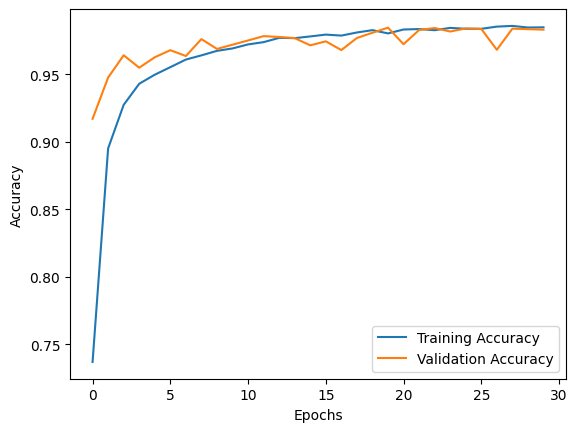

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
